<a href="https://colab.research.google.com/github/palakbh18/Natural_language_processing/blob/master/1116552_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
# Get the train/test split package from sklearn for preparing our dataset to
# train and test the model with
from sklearn.model_selection import train_test_split
# Import the numpy library to work with and manipulate the data
import numpy as np

In [0]:
# Reads a comma-separated value (CSV) file
dataset = pd.read_csv('/content/housing.csv')
# The path to your .csv file
# Remove any incomplete entries
dataset = dataset.dropna()
# View the first five rows of the dataset
print("Here are the first ten rows of the dataset:")
data=dataset.head(10)
print(data)
x=dataset.head(100)


Here are the first ten rows of the dataset:
   longitude  latitude  ...  median_house_value  ocean_proximity
0    -122.23     37.88  ...            452600.0         NEAR BAY
1    -122.22     37.86  ...            358500.0         NEAR BAY
2    -122.24     37.85  ...            352100.0         NEAR BAY
3    -122.25     37.85  ...            341300.0         NEAR BAY
4    -122.25     37.85  ...            342200.0         NEAR BAY
5    -122.25     37.85  ...            269700.0         NEAR BAY
6    -122.25     37.84  ...            299200.0         NEAR BAY
7    -122.25     37.84  ...            241400.0         NEAR BAY
8    -122.26     37.84  ...            226700.0         NEAR BAY
9    -122.25     37.84  ...            261100.0         NEAR BAY

[10 rows x 10 columns]


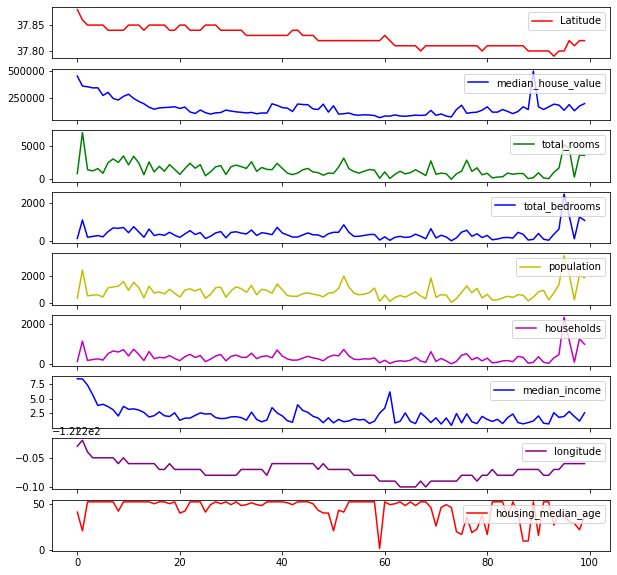

In [0]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=9, ncols=1,sharex=True)
axes[0].plot(x['latitude'], color='r', label='Latitude')
axes[0].legend(loc="upper right")
axes[1].plot(x['median_house_value'], color='b', label='median_house_value')
axes[1].legend(loc="upper right")
axes[2].plot(x['total_rooms'], color='g', label='total_rooms')
axes[2].legend(loc="upper right")
axes[3].plot(x['total_bedrooms'], color='b', label='total_bedrooms')
axes[3].legend(loc="upper right")
axes[4].plot(x['population'], color='y', label='population')
axes[4].legend(loc="upper right")
axes[5].plot(x['households'], color='m', label='households')
axes[5].legend(loc="upper right")
axes[6].plot(x['median_income'], color='b', label='median_income')
axes[6].legend(loc="upper right")
axes[7].plot(x['longitude'], color='purple', label='longitude')
axes[7].legend(loc="upper right")
axes[8].plot(x['housing_median_age'], color='r', label='housing_median_age')
axes[8].legend(loc="upper right")

fig.set_size_inches(10,10)



In [0]:
# We will predict the "median_house_value" column
Y = dataset['median_house_value']
# The remainder of the columns will be used to predict Y
# Select from the "longitude" column to the "median_income" column
X = dataset.loc[:,'longitude':'median_income']

In [0]:
import random 
# Setting the seed
random_state = 2003
# Splits the dataset so 70% is used for training and 30% for testing
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
# Converts the datasets to numpy arrays to work with our PyTorch model
x_train_np = x_train.to_numpy()
y_train_np = y_train.to_numpy()
# Convert the testing data
x_test_np = x_test.to_numpy()
y_test_np = y_test.to_numpy()

In [0]:
# Import the pytorch library
import torch
# Import the 1D convolution layer
# Since we’re inputting a 1-dimensional row of data, we can’t use 2D or 3D
from torch.nn import Conv1d
# Import the max pooling layer
from torch.nn import MaxPool1d
# Import the flatten layer
from torch.nn import Flatten
# Import the linear layer
from torch.nn import Linear
# Import the ReLU activation function
from torch.nn.functional import relu
# Import the DataLoader and TensorDataset libraries from PyTorch
# to work with our datasets
from torch.utils.data import DataLoader, TensorDataset



In [0]:
# Our class MUST be a subclass of torch.nn.Module
class CnnRegressor(torch.nn.Module):
# Define the initialization method
  def __init__(self, batch_size, inputs, outputs):
# Initialize the superclass and store the parameters
    super(CnnRegressor, self).__init__()
    self.batch_size = batch_size
    self.inputs = inputs
    self.outputs = outputs  
# Define the input layer
# (input channels, output channels, kernel size)
    self.input_layer = Conv1d(inputs, batch_size,1)
    # Batch normalization
    self.input= torch.nn.BatchNorm1d(inputs) 
# Define a max pooling layer
    self.max_pooling_layer = MaxPool1d(1)
# Define another convolution layer
    self.conv_layer = Conv1d(batch_size, 128,1)
# Define a max pooling layer
    self.max_pooling_layer2 = MaxPool1d(1)
    self.flatten_layer = Flatten() 
# Define a linear layer
# (inputs, outputs)
    self.linear_layer = Linear(128, 64)   
# Finally, define the output layer
    self.output_layer = Linear(64, outputs)
       
# Define a method to feed inputs through the model
  def feed(self, input):
# Reshape the entry so it can be fed to the input layer
# Although we’re using 1D convolution, it still expects a 3D array to process in a 1D fashion
    input = input.reshape((self.batch_size, self.inputs, 1))
# Get the output of the first layer and run it through the
# the ReLU activation function
    output = relu(self.input_layer(input))
# Get the output of the max pooling layer
    output = self.max_pooling_layer(output)
# Get the output of the second convolution layer and run it
# through the ReLU activation function
    output = relu(self.conv_layer(output))
# Get the output of the flatten layer
    output = self.flatten_layer(output)
# Get the output of the linear layer and run it through the
# ReLU activation function
    output = self.linear_layer(output)
# Finally, get the output of the output layer and return it
    output = self.output_layer(output)
    return output

In [0]:
# Import the SGD (stochastic gradient descent) package from pytorch for
# our optimizer
from torch.optim import SGD
# Import the L2Loss (mean absolute error loss) package from pytorch for
# our performance measure
from torch.nn import L1Loss
# Import the R^2 score package from pytorch's ignite for our score measure
# This package is not installed by default so the next line does that
!pip install pytorch-ignite
from ignite.contrib.metrics.regression.r2_score import R2Score

     |████████████████████████████████| 112kB 3.0MB/s 


In [0]:
# Define the batch size we'd like to use
batch_size = 32
# (batch size, X columns, Y columns)
model = CnnRegressor(batch_size, X.shape[1], 1)
# Set the model to use the GPU for processing
model.cuda()




CnnRegressor(
  (input_layer): Conv1d(8, 32, kernel_size=(1,), stride=(1,))
  (input): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pooling_layer): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_layer): Conv1d(32, 128, kernel_size=(1,), stride=(1,))
  (max_pooling_layer2): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (flatten_layer): Flatten()
  (linear_layer): Linear(in_features=128, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)

In [0]:
# This method will return the average L1 loss and R^2 score
# of the passed model on the passed DataLoader
def model_loss(model, dataset, train = False, optimizer = None):
# Cycle through the batches and get the average L1 loss
  performance = L1Loss()
  score_metric = R2Score()
  avg_loss = 0
  avg_score = 0
  count = 0
  for input, output in iter(dataset):
# Get the model's predictions for the training dataset
    predictions = model.feed(input)
# Get the model's loss
    loss = performance(predictions, output)
# Get the model's R^2 score
    score_metric.update([predictions, output])
    score = score_metric.compute()
    if(train):
# Clear any errors so they don't cummulate
      optimizer.zero_grad()
# Compute the gradients for our optimizer
      loss.backward()
# Use the optimizer to update the model's parameters based on the gradients
      optimizer.step()
# Store the loss and update the counter
    avg_loss += loss.item()
    avg_score += score
    count += 1
  return avg_loss / count, avg_score / count

Epoch 1:
	Loss = 126787.1491907231
	R^2 Score = -1.8095147853900302
Epoch 2:
	Loss = 94145.81266640975
	R^2 Score = -0.5433087122167115
Epoch 3:
	Loss = 80240.05760404989
	R^2 Score = 0.1745427722542152
Epoch 4:
	Loss = 78817.84995095292
	R^2 Score = 0.21755494129917144
Epoch 5:
	Loss = 77235.5844222954
	R^2 Score = 0.2308121079246281
Epoch 6:
	Loss = 75580.0664150084
	R^2 Score = 0.2694600399219649
Epoch 7:
	Loss = 73808.54001716648
	R^2 Score = 0.3121771517497755
Epoch 8:
	Loss = 72199.46123528587
	R^2 Score = 0.3378978944639302
Epoch 9:
	Loss = 70393.86757286996
	R^2 Score = 0.36588153263264606
Epoch 10:
	Loss = 69047.99662801289
	R^2 Score = 0.3857946133000937
Epoch 11:
	Loss = 68087.14263067544
	R^2 Score = 0.4029699050565121
Epoch 12:
	Loss = 66898.88224320348
	R^2 Score = 0.42922560601043935
Epoch 13:
	Loss = 65439.44678391256
	R^2 Score = 0.43317021317018456
Epoch 14:
	Loss = 64285.560249089125
	R^2 Score = 0.4561374367635374
Epoch 15:
	Loss = 62737.104934487106
	R^2 Score = 0.

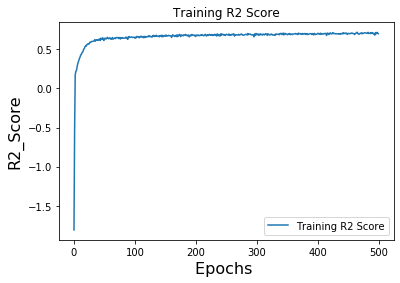

<Figure size 432x288 with 0 Axes>

In [0]:
#### Calcaulte inference time
from time import time
start_time = time()
# Define the number of epochs to train for
train_score=[]
epochs = 500
# Define the performance measure and optimizer
optimizer = torch.optim.Adam(model.parameters())
# Convert the training set into torch variables for our model using the GPU
# as floats. The reshape is to remove a warning pytorch outputs otherwise.
inputs = torch.from_numpy(x_train_np).cuda().float()
outputs = torch.from_numpy(y_train_np.reshape(y_train_np.shape[0], 1)).cuda().float()
# Create a DataLoader instance to work with our batches
tensor = TensorDataset(inputs, outputs)
loader = DataLoader(tensor, batch_size, shuffle=True, drop_last=True)
# Start the training loop
for epoch in range(epochs):
# Cycle through the batches and get the average loss
  avg_loss, avg_r2_score = model_loss(model, loader, train=True, optimizer=optimizer)
# Output the average loss
  print("Epoch " + str(epoch + 1) + ":\n\tLoss = " + str(avg_loss) + "\n\tR^2 Score = " + str(avg_r2_score))
  train_score.append(avg_r2_score)
#### Time for training the model
time_taken = time() - start_time
print("Inference time: %.4f s" % time_taken)
plt.plot(range(len(train_score)),train_score, label='Training R2 Score')
plt.title('Training R2 Score')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('R2_Score',fontsize=16)
plt.legend()
plt.figure()
plt.show()

In [0]:
# Convert the testing set into torch variables for our model using the GPU
# as floats
inputs = torch.from_numpy(x_test_np).cuda().float()
outputs = torch.from_numpy(y_test_np.reshape(y_test_np.shape[0], 1)).cuda().float()
# Create a DataLoader instance to work with our batches
tensor = TensorDataset(inputs, outputs)
loader = DataLoader(tensor, batch_size, shuffle=True, drop_last=True)
# Output the average performance of the model
avg_loss, avg_r2_score = model_loss(model, loader)
print("The model's L1 loss is: " + str(avg_loss))
print("The model's R^2 score is: " + str(avg_r2_score))

# Save the model in a file
checkpoint = {'model': CnnRegressor(32,8,1),
          'state_dict': model.state_dict(),
          'optimizer' : optimizer.state_dict()}
torch.save(checkpoint, '1116552_1dconv_reg')


The model's L1 loss is: 43703.765921547776
The model's R^2 score is: 0.7015827232291525


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CnnRegressor. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
